# ````Galytix ````

### `Loading libraries`

In [15]:
import tensorflow as tf
import os
import gensim
import spacy
import numpy as np
import pandas as pd


from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance

In [26]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stop = set(stopwords.words('english'))
from nltk import ngrams
from textblob import Word

In [9]:
path_dir  = os.getcwd() + "/Python_exercise/"

### `Text preprocessing`

In [3]:
# Average Word Length
def avg_word(sentence):
        words = sentence.split()
        if len(words) == 0:
            pass
        else:
            return (sum(len(word) for word in words)/len(words))


# basic preprocessing steps
def text_processing(data, colum_name):

    # Number of Words
    data['word_count'] = data[colum_name].apply(lambda x: len(str(x).split(" ")))

    # Number of characters
    data['char_count'] = data[colum_name].str.len()
    
    # average word count for each word
    data['avg_word'] = data[colum_name].apply(lambda x: avg_word(x))

    # Number of stopwords
    data['stopwords'] = data[colum_name].apply(lambda x: len([x for x in x.split() if x in stop]))
    
    # Number of mentions or hastags
    data['hastags'] = data[colum_name].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
    
    # Number of numerics
    data['numerics'] = data[colum_name].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
    
    # Number of uppercase words
    data['upper'] = data[colum_name].apply(lambda x: len([x for x in x.split() if x.isupper()]))
    
    # Preprocessing test
    data[colum_name] = data[colum_name].apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Remove twitter handlers 
    data[colum_name] = data[colum_name].str.replace('@[^\s]+', " ")
    
    # removing special characters
    data[colum_name] = data[colum_name].str.replace("[^a-zA-Z#]", " ")
    
    # Removing Punctuation
    data[colum_name] = data[colum_name].str.replace('[^\w\s]',' ')
    
#     # Removing stopwords
#     data[colum_name] = data[colum_name].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#     # Common word removal
#     freq = pd.Series(' '.join(data[colum_name]).split()).value_counts()[:25]

#     freq_ind = list(freq.index)
#     data[colum_name] = data[colum_name].apply(lambda x: " ".join(x for x in x.split() if x not in freq_ind))

    # spelling correct removal
    # tweeet_data['text'].apply(lambda x: str(TextBlob(x).correct()))
    
    # small words
    data[colum_name] = data[colum_name].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
    
    # Lemmatization
    data[colum_name] = data[colum_name].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    return data

### `Importing pretrained vectors `

In [18]:
# Path to google news vectors
google_news_path = "/Users/avaneeshkumar/Desktop/GoogleNews-vectors-negative300.bin"

# Load google news vecs in gensim
model = gensim.models.KeyedVectors.load_word2vec_format(google_news_path, binary=True)

words = pd.read_csv(path_dir+"words.csv")

# creating corpus list for words
corpus = words['Words'].dropna().values
corpus_list = [nltk.word_tokenize(title) for title in corpus]

In [19]:
corpus_list[:10]

[['a'],
 ['airline'],
 ['airlines'],
 ['all'],
 ['and'],
 ['are'],
 ['been'],
 ['breakdown'],
 ['breakup'],
 ['by']]

### `Util functions `

In [20]:
# we can use TFIDF or Count_vectorises but here we'll use MeanEmbeddingVectoriser
class MeanEmbeddingVectorizer(object):

    def __init__(self, word_model):
        self.word_model = word_model
        self.vector_size = word_model.wv.vector_size

    def fit(self):  # comply with scikit-learn transformer requirement
        return self

    def transform(self, docs):  # comply with scikit-learn transformer requirement
        doc_word_vector = self.word_average_list(docs)
        return doc_word_vector

    def word_average(self, sent):
        """
        Compute average word vector for a single doc/sentence.


        :param sent: list of sentence tokens
        :return:
            mean: float of averaging word vectors
        """
        
        try:
            
            mean = []
            for word in sent:
                if word in self.word_model.wv.vocab:
                    mean.append(self.word_model.wv.get_vector(word))

            if not mean:  # empty words
                # If a text is empty, return a vector of zeros.
                #logging.warning("cannot compute average owing to no vector for {}".format(sent))
                return np.zeros(self.vector_size)
            else:
                mean = np.array(mean).mean(axis=0)
                return mean
            
        except Exception as e:
            print (str(e))
            
    def word_average_list(self, docs):
        """
        Compute average word vector for multiple docs, where docs had been tokenized.

        :param docs: list of sentence in list of separated tokens
        :return:
            array of average word vector in shape (len(docs),)
        """
        return np.vstack([self.word_average(sent) for sent in docs])

## `Task 1 & 2`

* Obtain the word2vec vector for each word in present in the file words.csv (skip the first row)
* L2 distance (Euclidean distance) between each pair of words

High level description of the task:
* Post completing the task of creating embeddings -  retruned (word2Vec file)
* Using the file created above we will use pdist from scipy libarary
* Calculate the ecuclidian distance row-wise (to using matrix transpose)
* Saving the file as a matrix containing euclidian distances

In [82]:
def dist_vector_creation(model, corpus_list, phrase=False, bigram=False):
    
    """
    Getting the eucledian distance and also converting the word to vector
    
    :params model: model used
    :param corpus_list: the list of lists created as input for transforming
    :param phrase: boolean (if phrase input provided or not)
    :param bigram: if corpus input contains corpus list containing bigrams created from 
    gensim pharse extractor
    
    :return:
    saves files depending on phrase and bigram params provided
    
    """
    
    try:
        
        path_dir  = os.getcwd() + "/Python_exercise/"

        mean_vec_tr = MeanEmbeddingVectorizer(model)
        doc_vec = mean_vec_tr.transform(corpus_list)

        df_vector = pd.DataFrame(doc_vec).T
        df_vector.columns = range(0,len(corpus_list))

        print ("Task 1************")
        print ("Embedded vector space shape: ", df_vector.shape, )

        if phrase == True:
            df_vector.to_csv(path_dir+ "phrase_vec.csv", index=False)

        elif phrase == False:
            df_vector.to_csv(path_dir+ "word_vec.csv", index=False)
            

        print ("******************", "\n")

        # making a tranform of the matrix for using pdist
        dist = pdist(df_vector.T, 'euclidean')
        df_dist = pd.DataFrame(squareform(dist))

        print ("Task 2************")
        print ("Eucledian Matrix: ", df_dist.shape)
        print ("******************")

        if (phrase == True) and (bigram==True):
            df_dist.to_csv(path_dir+ "eucl_phrase_dist_matrix.csv", index=False)
            
        elif (phrase == True) and (bigram == False):
            df_dist.to_csv(path_dir+ "eucl_phrase_dist_matrix_bigram.csv", index=False)
            
        elif (phrase == False) and (bigram == False):
            df_dist.to_csv(path_dir+"eucl_word_dist_matrix.csv", index=False)
            
        else:
            print ("\n","NOTE: Please keep Bigram as False when phrase is False *** FALSE Output")
        
        
    except Exception as e:
        print(str(e))
    
    return 'Please check the mentioned folder for saved files: {}'.format(path_dir)

In [84]:
dist_vector_creation(model, corpus_list, phrase=False, bigram=False)

Task 1************
Embedded vector space shape:  (300, 70)
****************** 

Task 2************
Eucledian Matrix:  (70, 70)
******************


'Please check the mentioned folder for saved files: /Users/avaneeshkumar/Downloads/Docker/DL/NLP-using-tf/NLP/Python_exercise/'

## `Task 3: Phrase  embeddings`

In [88]:
print ("Testing: ",  path_dir)

Testing:  /Users/avaneeshkumar/Downloads/Docker/DL/NLP-using-tf/NLP/Python_exercise/


In [89]:
# load phrase
phrase  = pd.read_csv(path_dir+'phrases.csv')

### `Task (a)`

Steps:
* Loading the csv 
* Use unigram or bigram
* Use the same code for unigram embedidngs 
* For bigram (write a funtion returning bigrams using Phrase functionality form gensim)
* create bigram and use word2vec (same function as used above to create wmbeddings)
* write a function to sort N provided elements putting the above matrix as input

### `Task (b)`

### `Phrase parsing using Phrase functionality in word2Vec`

In [90]:
def bigramPhraseParsing(phrase):
    
    """
    Providing phrase pasing using word2vec and gensim for bigram creation for testing purpose
    
    :param phrase: files phrase as input
    
    :return:
    returns token list created using gensim
    """
    
    try:
        #creating a sentence stream
        sentence_stream = [doc.split(" ") for doc in phrase["Phrases"].to_list()]
        #print(sentence_stream)

        # creating bigrams
        bigram = Phrases(sentence_stream, min_count=1, threshold=2, delimiter=b' ')

        # Bigram parser
        bigram_phraser = Phraser(bigram)

        # collectiong tokens created
        tokens = []
        for sent in sentence_stream:
            tokens_ = bigram_phraser[sent]
            tokens.append(tokens_)
    
    except Exception as e:
        print (str(e))
    
    return tokens

#### `Unigram Phase Embedding`

In [99]:
# creatinf phrase corpus list (unigram)
corpus_phrase = phrase['Phrases'].dropna().values
corpus_phrase_list = [nltk.word_tokenize(title) for title in corpus_phrase]

In [102]:
# not removoing stop words for finding the text similarity
text_processing(phrase, "Phrases")[:5]

,Phrases,word_count,char_count,avg_word,stopwords,hastags,numerics,upper
0,how company compare to it peer,6,30,4.166667,3,0,0,0
1,what is the detailed income statement breakdow...,11,75,5.909091,4,0,0,0
2,world premium penetration,3,25,7.666667,0,0,0,0
3,how doe the forecasted insurance premium penet...,14,88,5.357143,5,0,0,0
4,what are the total loss for company in country...,12,62,4.250000,5,0,0,0


In [103]:
print ("Using the same function we can find the similarity")
dist_vector_creation(model, corpus_phrase_list, phrase = True, bigram= False)

Using the same function we can find the similarity
Task 1************
Embedded vector space shape:  (300, 14)
****************** 

Task 2************
Eucledian Matrix:  (14, 14)
******************


'Please check the mentioned folder for saved files: /Users/avaneeshkumar/Downloads/Docker/DL/NLP-using-tf/NLP/Python_exercise/'

#### `Bigram tokens from Phrase functionality of Gensim`

In [116]:
dist_vector_creation(model, corpus_phrase_list, phrase = True, bigram=True)

Task 1************
Embedded vector space shape:  (300, 14)
****************** 

Task 2************
Eucledian Matrix:  (14, 14)
******************


'Please check the mentioned folder for saved files: /Users/avaneeshkumar/Downloads/Docker/DL/NLP-using-tf/NLP/Python_exercise/'

### `Task (c)`

### `Sorting top N elements in phrase`

In [117]:
# reading phrase data
phrase_euc_mat = pd.read_csv(path_dir+"eucl_phrase_dist_matrix.csv")

In [118]:
#def give_top3(phase_euc_mat, index):
index = 1
values = phrase_euc_mat.iloc[index]

In [119]:
def topSimilarityIndex(df, index, number_of_elements):
    
    """finding top n similarity provided file and index for phrase or word
    
    :param df: input vector df
    :param index: index values to be tested
    :param number of elemnst: # of elements reuiqred
    
    :retrun:
    index values in descending order based on #of elements provided
    """
    
    param
    
    try:
        if number_of_elements < len(df):
            return df.iloc[index].sort_values(ascending=False).index[:number_of_elements]
        else:
            print ("Provide a smaller number for numer_of_elements")
            
    except Exception as e:
        print (str(e))

In [120]:
topSimilarityIndex(phrase_euc_mat,5, 4)

Index(['0', '7', '8', '1'], dtype='object')

### `Note`

* The mean distance between data points diverges and looses its meaning which in turn leads to the divergence of the Euclidean distance, the most common distance used for clustering

## `BONUS`

### `Dimnetionality Reduction (a)`

* Principal component analysis
* Multidimensional scaling

and many other but we will use PCA

In [121]:
word_embeddings_vec = pd.read_csv(path_dir+"word_vec.csv")

#### `Using PCA`

In [150]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
x_pca = pca.fit_transform(word_embeddings_vec.T)

In [151]:
df_pca_= pd.DataFrame(x_pca).T

In [167]:
df_pca_.T

,0,1,2,3,4,5,6,7,8,9
0,-0.353700,-0.011652,0.027775,-0.164028,0.127332,0.078816,0.086673,-0.013294,0.031315,-0.100928
1,0.862264,1.692196,1.607591,0.143006,-0.926471,-0.712134,-0.140165,0.376682,-0.567739,-0.553327
2,1.211664,2.062070,1.629785,0.252843,-1.002935,-0.522454,-0.100598,0.298484,-0.545156,-0.643022
3,-0.590948,-0.005651,0.177225,-0.131001,0.257146,0.090191,0.191299,-0.109381,-0.013928,-0.002695
4,-0.353700,-0.011652,0.027775,-0.164028,0.127332,0.078816,0.086673,-0.013294,0.031315,-0.100928
...,...,...,...,...,...,...,...,...,...,...
65,-0.250966,-0.356228,-0.054318,0.459341,-0.177026,0.417970,0.300085,0.085099,0.181306,-0.337674
66,0.049010,0.331269,-0.848209,0.079684,0.139072,0.316089,-0.309103,0.990691,-0.061935,-0.214631
67,-0.595090,-0.149425,0.312207,-0.129114,0.255118,-0.128984,-0.106258,0.177369,-0.015242,0.347458
68,-0.547574,0.645790,-0.611973,-0.016706,0.236604,-0.400699,0.021069,-0.450560,-0.196915,0.143689


### `Not recommended`

* Using clustering for dimnetionality reduction like T-sne, but this is never recommended and also its n_componets should be lower than four

In [160]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [165]:
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_embeddings_vec.T)
labels = words

In [ ]:
### Not very useful though

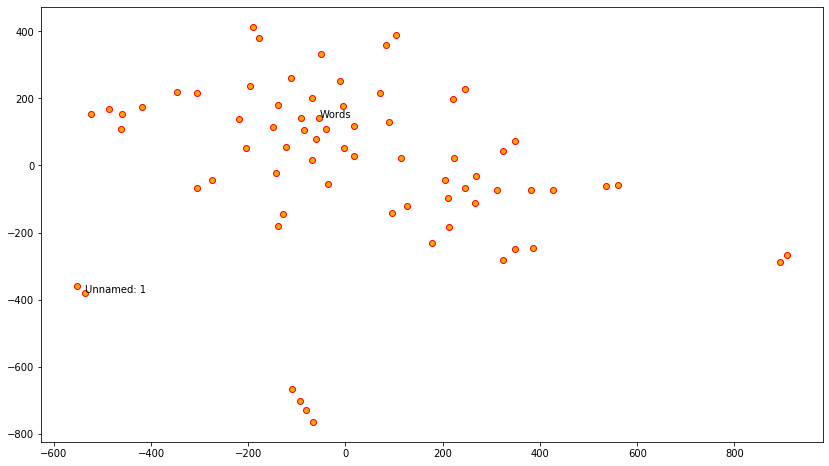

In [166]:
# plt.figure(figsize=(14, 8))
# plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
# for label, x, y in zip(labels, T[:, 0], T[:, 1]):
#     plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### `Heat Map (b)`

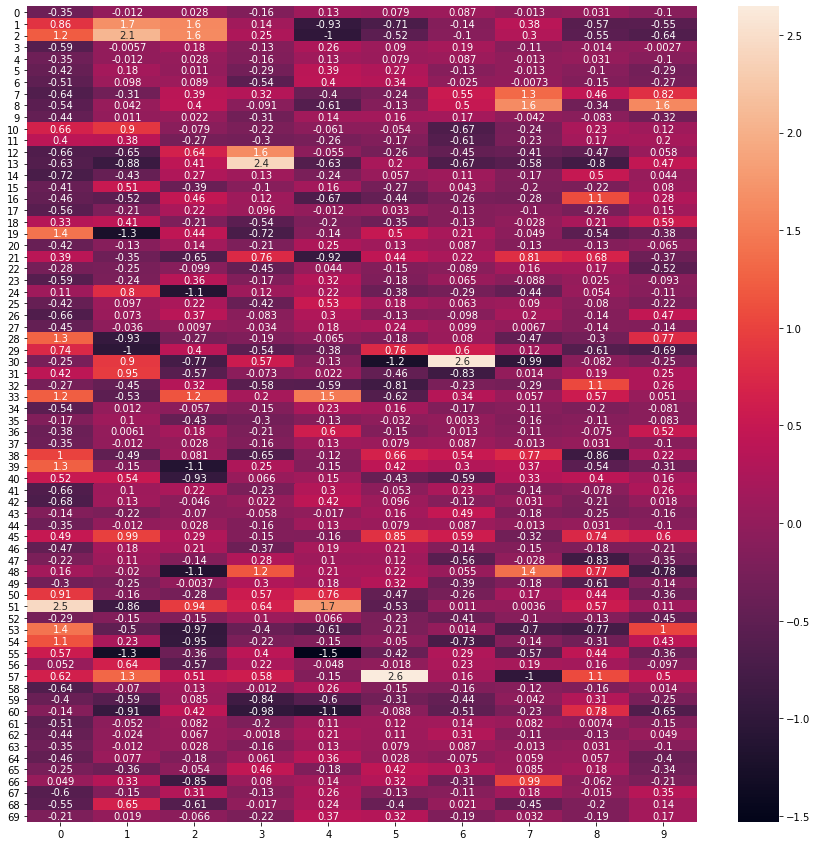

In [178]:
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= [range(0,70)]
Cols = [range(0,10)]
df = df_pca_.T

plt.figure(figsize=(15,15))
sns.heatmap(df, annot=True)

*************************

# END *****

In [60]:
# model = gensim.models.Word2Vec(size=150, window=10, min_count=2, sg=1, workers=10)
# model.build_vocab(words) 

In [153]:
# model.train(sentences=Word_list, total_examples=len(Word_list), epochs=model.iter)